<a href="https://colab.research.google.com/github/zeng-zr/FacePerceptionProject/blob/main/load_ECoG_faceshouses_alldat%5B0%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Miller ECoG data of faces/houses (+ noise)

includes some visualizations

In [ ]:
# @title Data retrieval
import os, requests

fname = 'faceshouses.npz'
url = "https://osf.io/argh7/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Install packages (`nilearn`, `nimare`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here.
#dat1 = alldat[1][0]#没有key_press
#dat2 = alldat[1][1]
dat1=alldat[0][0]
dat2=alldat[0][1]

### Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. We plan to curate a few more before NMA starts. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

`alldat` contains 7 subjects each with two sessions `dat1` and `dat2`, and was originally used in these publications:

*Miller, Kai J., et al. "Face percept formation in human ventral temporal cortex." Journal of neurophysiology 118.5 (2017): 2614-2627.*

*Miller, Kai J., et al. "The physiology of perception in human temporal lobe is specialized for contextual novelty." Journal of neurophysiology 114.1 (2015): 256-263.*

*Miller, Kai J., et al. "Spontaneous decoding of the timing and content of human object perception from cortical surface recordings reveals complementary information in the event-related potential and broadband spectral change." PLoS computational biology 12.1 (2016): e1004660.*

*Miller, Kai J., et al. "The physiology of perception in human temporal lobe is specialized for contextual novelty." Journal of neurophysiology 114.1 (2015): 256-263.*

*Miller, Kai J., et al. "Spontaneous decoding of the timing and content of human object perception from cortical surface recordings reveals complementary information in the event-related potential and broadband spectral change." PLoS computational biology 12.1 (2016): e1004660.*

In this task, subjects in a clinical settings (with ECoG implants) are passively shown faces and house during the first experiment (`dat1`). Then in the second experiment in the same subjects (`dat2`), noise is added to face and houses images and the subject has to detect the faces by pressing a key. Two of the subjects don't have keypresses.

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size.

Experiment 1:
* `dat1['V']`: continuous voltage data (time by channels)
* `dat1['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat1['t_on']`: time of stimulus onset in data samples
* `dat1['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat1['stim_id`]: identity of stimulus from 1-100, with 1-50 being houses and 51-100 being faces
* `dat1['locs`]: 3D electrode positions on the brain surface

Experiment 2:
* `dat2['V`]: continuous voltage data (time by channels)
* `dat2['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat2['t_on']`: time of stimulus onset in data samples
* `dat2['t_off']`: time of stimulus offset, always 1000 samples after `t_on`, with no inter-stimulus interval
* `dat2['stim_id`]: identity of stimulus from 1-600 (not really useful, since we don't know which ones are the same house/face)
* `dat2['stim_cat']`: stimulus category (1 = house, 2 = face)
* `dat2['stim_noise']`: percent noise from 0 to 100
* `dat2['key_press']`: when the subject thought the image was a face
* `dat2['categories']`: categories legend (1 = house, 2 = face)
* `dat2['locs`]: 3D electrode positions on the brain surface


In [ ]:
from nilearn import plotting
from nimare import utils
from IPython.display import display, HTML


locs2 = dat1['locs']


view2 = plotting.view_markers(utils.tal2mni(locs2),
                              marker_labels=['%d'%k for k in np.arange(locs2.shape[0])],
                              marker_color='purple',
                              marker_size=3)

# 将两个视图并排显示
#display(HTML(f'<table><tr><td>{view1.get_iframe(width=400, height=400)}</td><td>{view2.get_iframe(width=400, height=400)}</td></tr></table>'))


## dat1

In [ ]:
# quick way to get broadband power in time-varying windows
#高通、低通滤波过程

from scipy import signal
V = dat1['V'].astype('float32')

b, a = signal.butter(3, [50], btype='high', fs=1000)# 巴特沃斯滤波器。在这段代码中，它被用来创建两个滤波器：一个高通滤波器（去除低于50 Hz的频率成分）和一个低通滤波器（去除高于10 Hz的频率成分）
V = signal.filtfilt(b, a, V, 0)
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

V = V/V.mean(0)

In [ ]:
# average the broadband power across all face stimuli and across all house stimuli

nt, nchan = V.shape
nstim = len(dat1['t_on'])
trange = np.arange(-200, 400)
ts = dat1['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 600, nchan))# 每一个时段的平均带宽功率

V_house = (V_epochs[dat1['stim_id'] <= 50]).mean(0)

V_face = (V_epochs[dat1['stim_id'] > 50]).mean(0)

得到的V是一定带宽频率下信号的功率，通过取信号的平方来计算的（V = np.abs(V)**2

**为什么从-200ms开始trange?**  
分析事件相关电位（Event-Related Potentials, ERPs）或其他时间序列数据时，通常会选择一个基线时期作为分析的起始点。这个基线时期通常位于刺激呈现或事件发生的前一段时间。
1. **基线校正**：基线时期可以用于校正或归一化数据，以便在事件发生之前和之后的时间段进行比较。
2. **早期响应分析**：在某些情况下，您可能想要观察事件发生之前的神经活动，以便理解大脑对即将到来的刺激的预期或准备。
3. **与其他试验同步**：如果您正在将这个实验与其他具有类似结构但不同时间戳的实验相比较，同步起始点可以使比较更加合理。

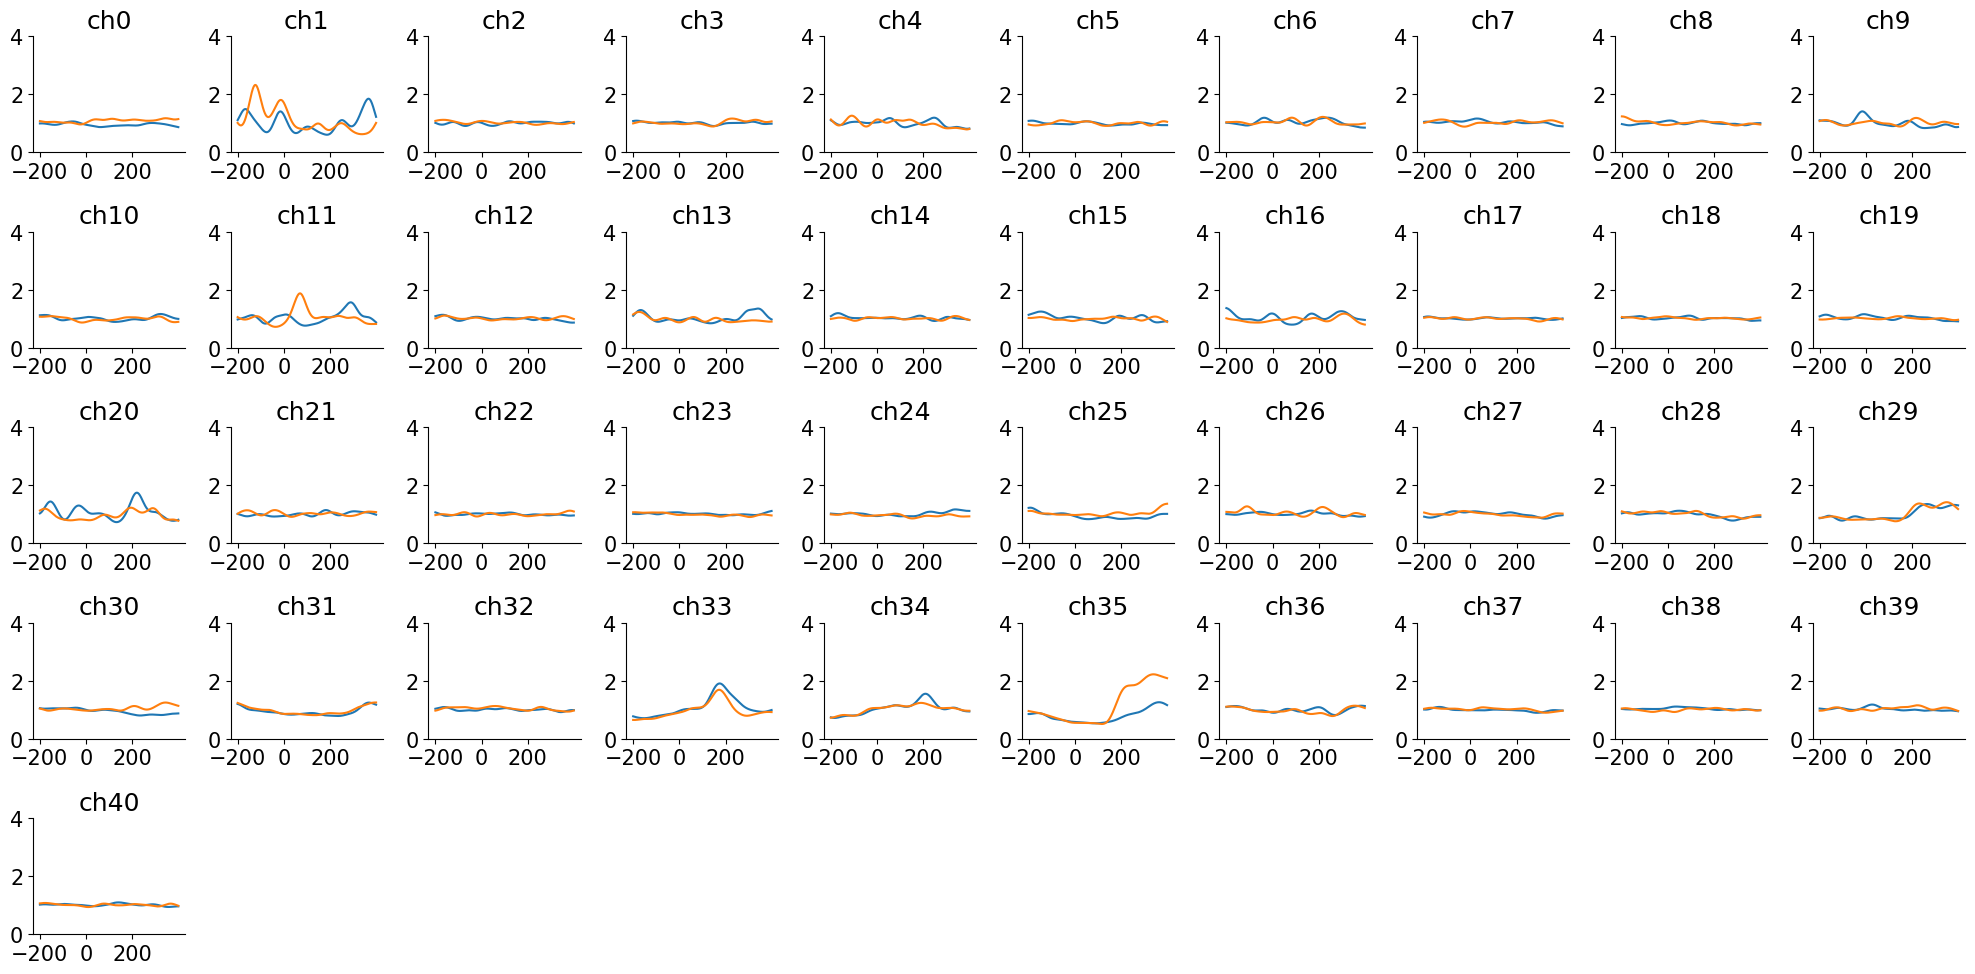

In [ ]:
# let's find the electrodes that distinguish faces from houses
plt.figure(figsize=(20, 10))
for j in range(len(dat1['locs'])):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(trange, V_house[:, j])
  plt.plot(trange, V_face[:, j])
  plt.title('ch%d'%j)
  plt.xticks([-200, 0, 200])
  plt.ylim([0, 4])
plt.show()

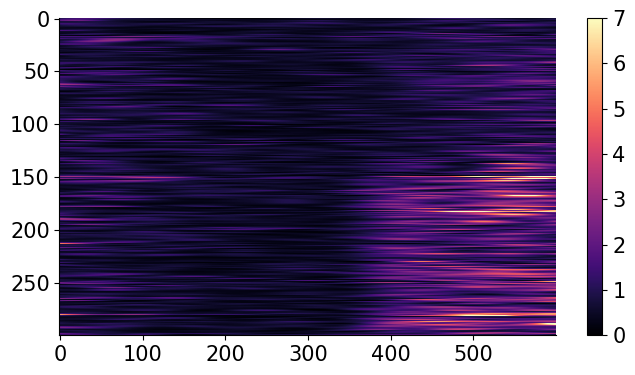

In [ ]:
# let's look at all the face trials for electrode 23 that has a good response to faces
# we will sort trials by stimulus id (1-50 is houses, 51-100 is faces)
plt.subplot(1, 3, 1)
isort = np.argsort(dat1['stim_id'])

plt.imshow(V_epochs[isort, :, 35].astype('float32'),
           aspect='auto', vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

## Step 1 right time period for analyses


In [ ]:
#只需修改trange即可
nt, nchan = V.shape
nstim = len(dat1['t_on'])

trange_2 = np.arange(130, 300)
trange_set= np.arange(trange_2[0],trange_2[-1]+1,step=15)
tlen=len(trange_2)
ts = dat1['t_on'][:, np.newaxis] + trange_2
#V_epochs = np.reshape(V[ts, :], (nstim, 600, nchan))
V_epochs = np.reshape(V[ts, :], (nstim, tlen, nchan))

V_house = (V_epochs[dat1['stim_id'] <= 50]).mean(0)

V_face = (V_epochs[dat1['stim_id'] > 50]).mean(0)



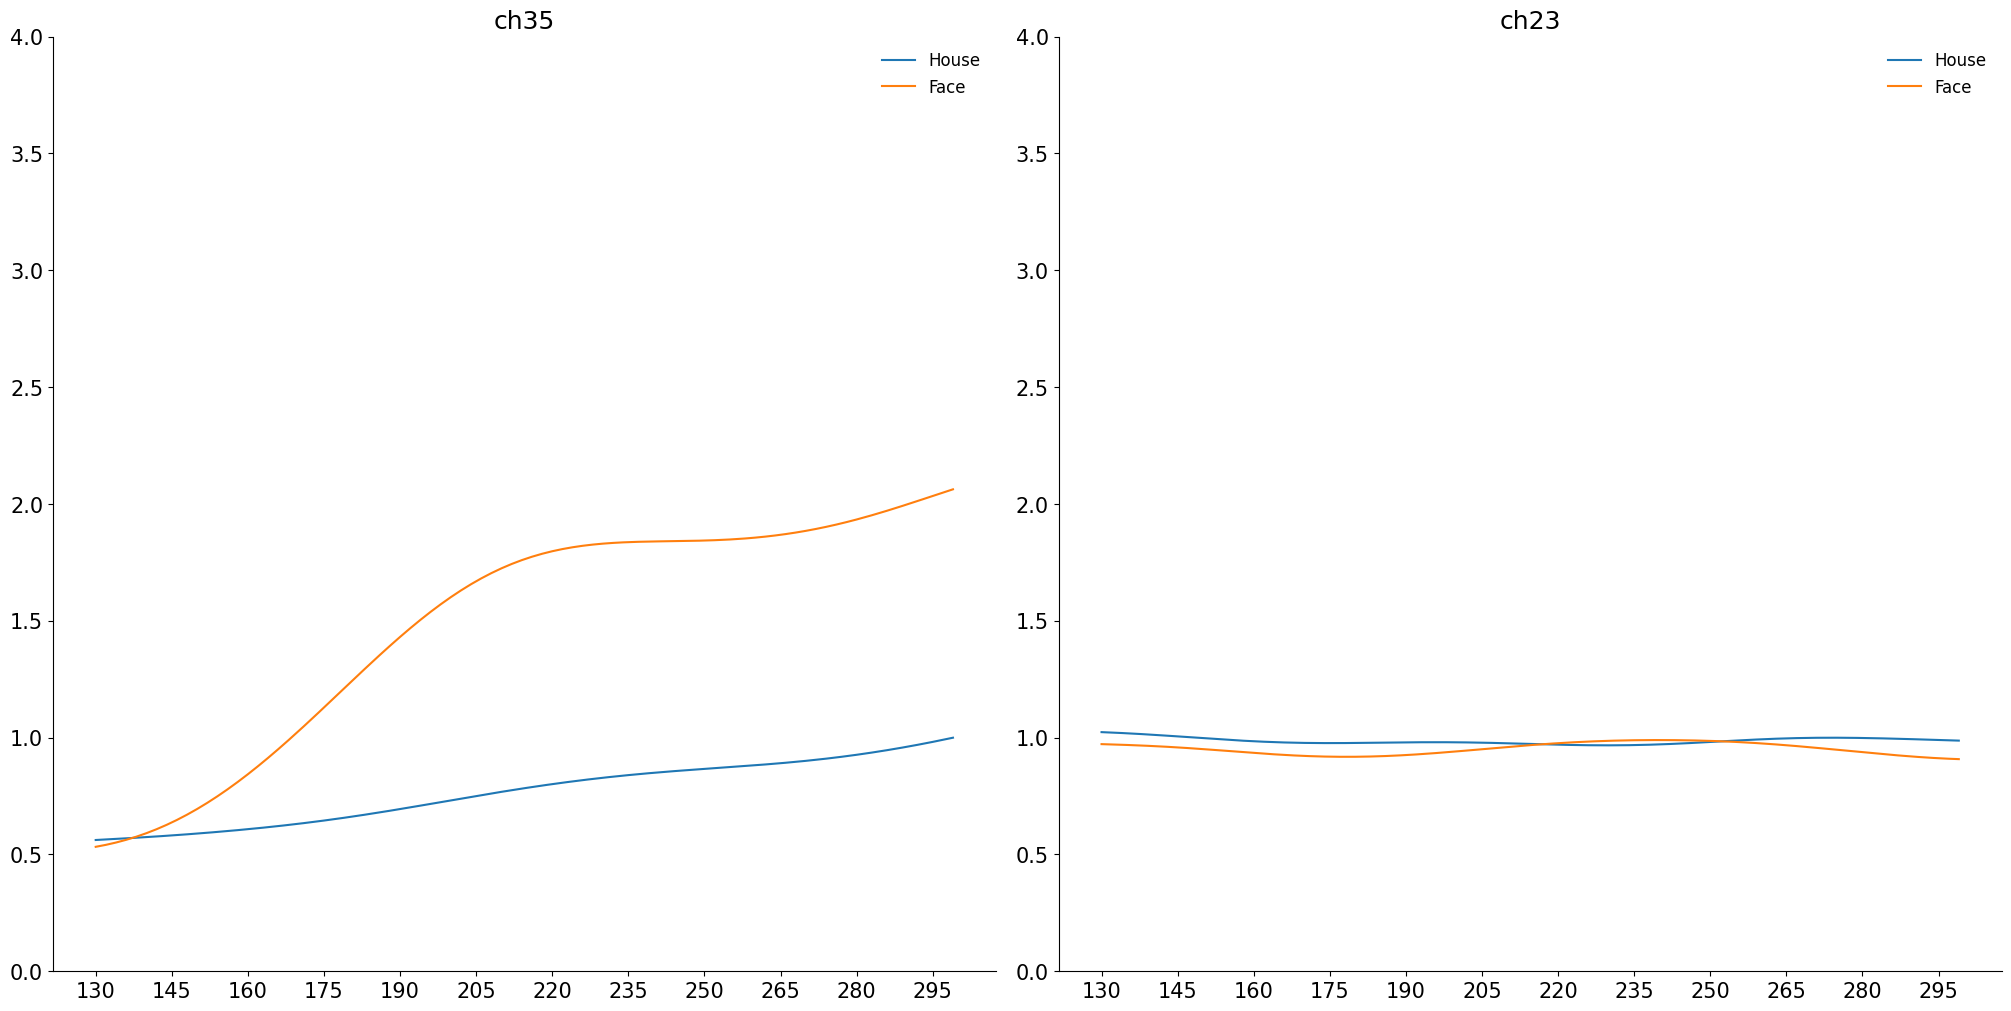

"\nfigure,axs = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)\nax1,ax2=axs\nax1.plot(trange, V_house[:,46],label='house')\nax1.plot(trange, V_face[:, 46],label='face')\nax2.plot(trange, V_house[:,43],label='house')\nax2.plot(trange, V_face[:, 43],label='face')\nax1.set_title('ch46')\nax1.set_xticks(trange_set)\nax1.set_ylim([0, 4])\nax1.legend(loc='upper right', fontsize=6, frameon=False)\nax2.set_title('ch43')\nax2.set_xticks(trange_set)\nax2.set_ylim([0, 4])\nax2.legend(loc='upper right', fontsize=6, frameon=False)\nplt.show()\n"

In [ ]:
#更简便的方法
def plot_channel(ax, trange, V_house, V_face, channel, title):
    ax.plot(trange_2, V_house[:, channel], label='House')
    ax.plot(trange_2, V_face[:, channel], label='Face')
    ax.set_title(title)
    ax.set_ylim([0, 4])
    ax.legend(loc='upper right', fontsize=12, frameon=False)

figure, axs = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)

channels = [35, 23]
titles = ['ch35', 'ch23']

for ax, channel, title in zip(axs, channels, titles):
    plot_channel(ax, trange_2, V_house, V_face, channel, title)
    ax.set_xticks(trange_set) # 如果 trange_set 是一个合适的范围

plt.show()

"""
figure,axs = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
ax1,ax2=axs
ax1.plot(trange, V_house[:,46],label='house')
ax1.plot(trange, V_face[:, 46],label='face')
ax2.plot(trange, V_house[:,43],label='house')
ax2.plot(trange, V_face[:, 43],label='face')
ax1.set_title('ch46')
ax1.set_xticks(trange_set)
ax1.set_ylim([0, 4])
ax1.legend(loc='upper right', fontsize=6, frameon=False)
ax2.set_title('ch43')
ax2.set_xticks(trange_set)
ax2.set_ylim([0, 4])
ax2.legend(loc='upper right', fontsize=6, frameon=False)
plt.show()
"""

In [ ]:
print('将' + str(trange_2[0]) + '到' + str(trange_2[-1]+1) + '作为时间间隔')

将130到300作为时间间隔


## Step 2: format a selectivity index

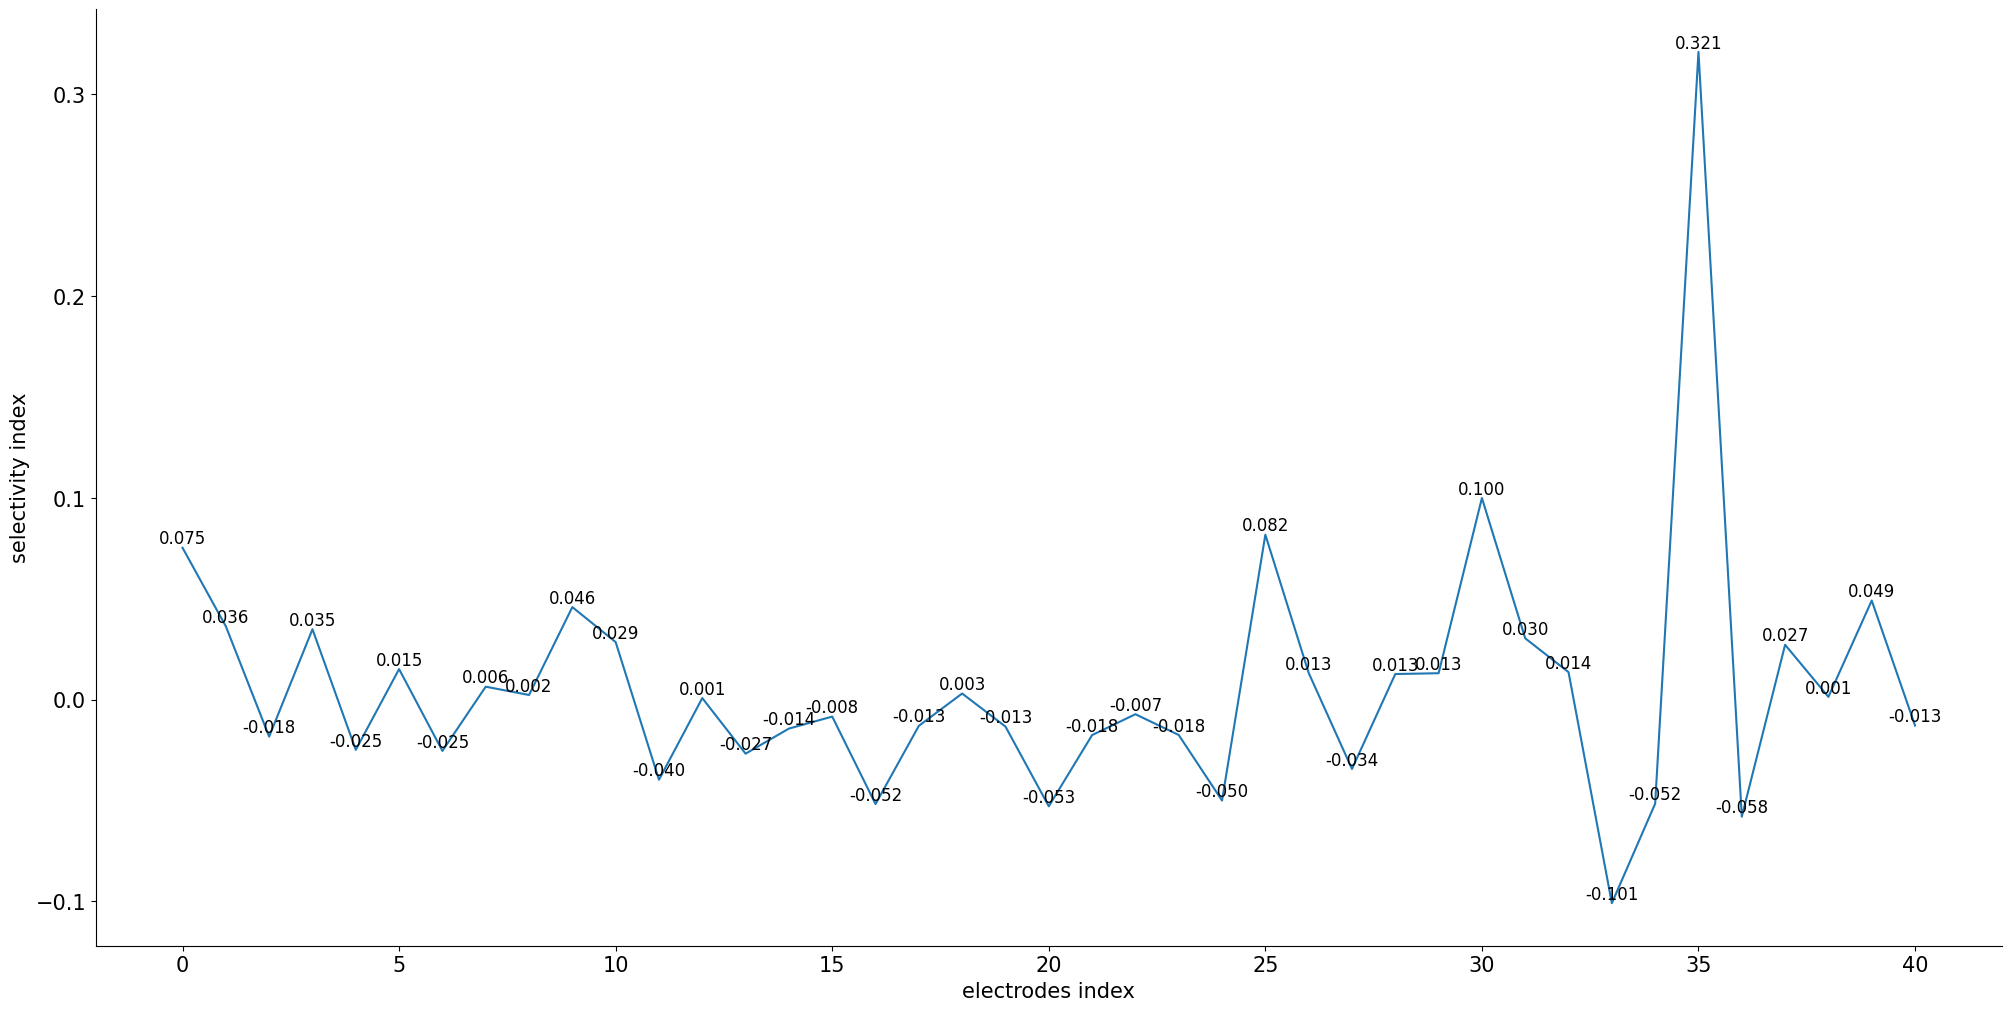

In [ ]:
"""
nt, nchan = V.shape
nstim = len(dat1['t_on'])
"""
trange_2 = np.arange(130, 300)
ts = dat1['t_on'][:, np.newaxis] + trange_2
V_epochs = np.reshape(V[ts, :], (nstim, len(trange_2), nchan))
"""
V_house = (V_epochs[dat1['stim_id'] <= 50]).mean(0)

V_face = (V_epochs[dat1['stim_id'] > 50]).mean(0)
"""
V_house_mean=V_house.mean(0)
V_face_mean=V_face.mean(0)

sele_index=(V_face_mean-V_house_mean)/(V_face_mean+V_house_mean)
plt.figure(figsize=(20, 10), constrained_layout=True)

plt.plot(sele_index)
plt.xlabel('electrodes index')
plt.ylabel('selectivity index')

for i, y in enumerate(sele_index):
    plt.text(i, y, '{:.3f}'.format(y), fontsize=12, ha='center', va='bottom')


plt.show()


由选择性指数计算得到，在41个电极中，trange(130,300)范围内，35号电极得到的两种平均响应相差最大且为正，说明对面部的分辨能力最强

## Step 3: responses for noisy data

In [ ]:
from scipy import signal
V2 = dat2['V'].astype('float32')

b, a = signal.butter(3, [50], btype='high', fs=1000)
V2 = signal.filtfilt(b, a, V2, 0)
V2 = np.abs(V2)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V2 = signal.filtfilt(b, a, V2, 0)

V2 = V2/V2.mean(0)

In [ ]:
nt, nchan = V2.shape
nstim = len(dat2['t_on'])
trange = np.arange(-200, 1000)
ts = dat2['t_on'][:, np.newaxis] + trange
V2_epochs = np.reshape(V2[ts, :], (nstim, 1200, nchan))
stim_cata=dat2['stim_cat'].squeeze()
noise_index=dat2['stim_noise'].squeeze()

In [ ]:
#选择噪声...以下的成分,并求第一维的均值
noise_limit=20 #尝试了0.2 0.4 0.6

V2_house_noise=(V2_epochs[(noise_index<=noise_limit)&(stim_cata==1)]).mean(0)
V2_face_noise=(V2_epochs[(noise_index<=noise_limit)&(stim_cata==2)]).mean(0)


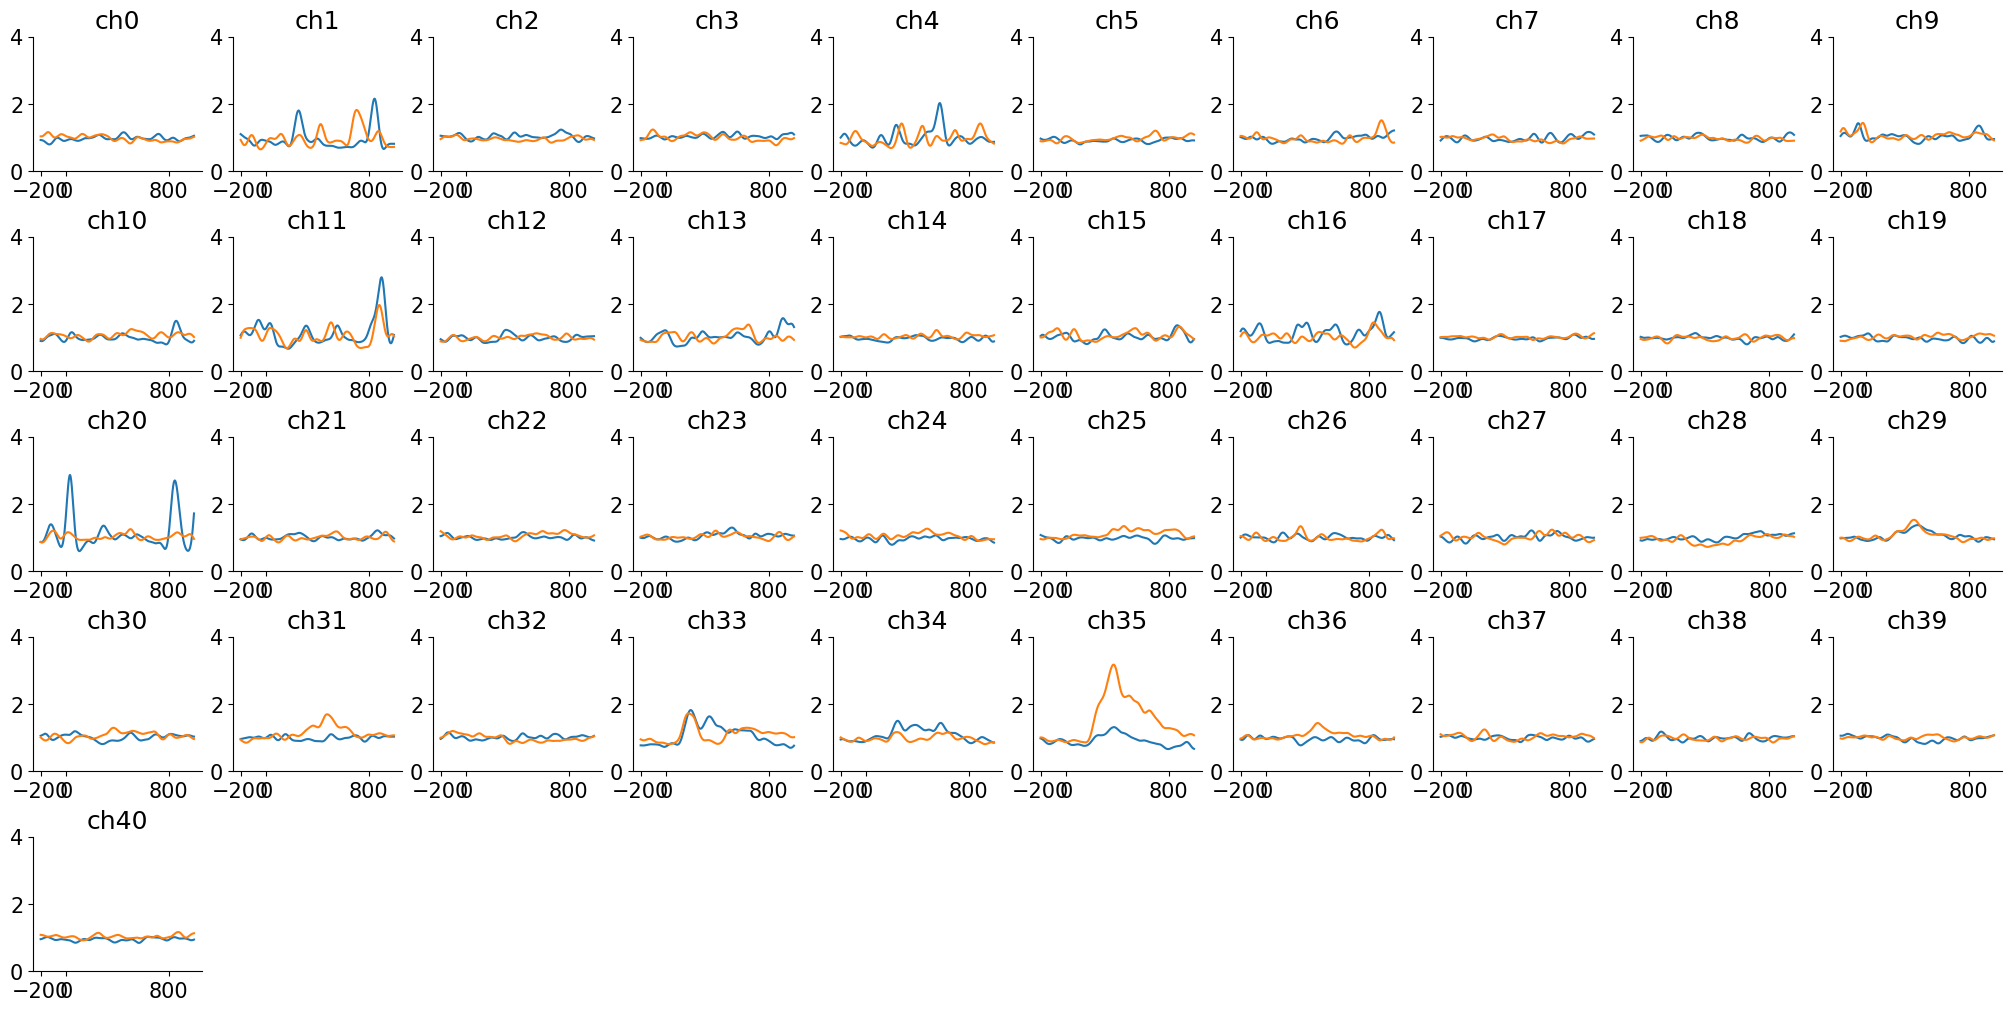

In [ ]:
plt.figure(figsize=(20, 10), constrained_layout=True)
for j in range(len(dat2['locs'])):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(trange, V2_house_noise[:, j])#blue
  plt.plot(trange, V2_face_noise[:, j])#orange
  plt.title('ch%d'%j)
  plt.xticks([-200, 0, 800])
  plt.ylim([0, 4])
plt.show()

In [ ]:
##ch35仍对面部图片有明显响应

### 35,23号电极的有噪响应

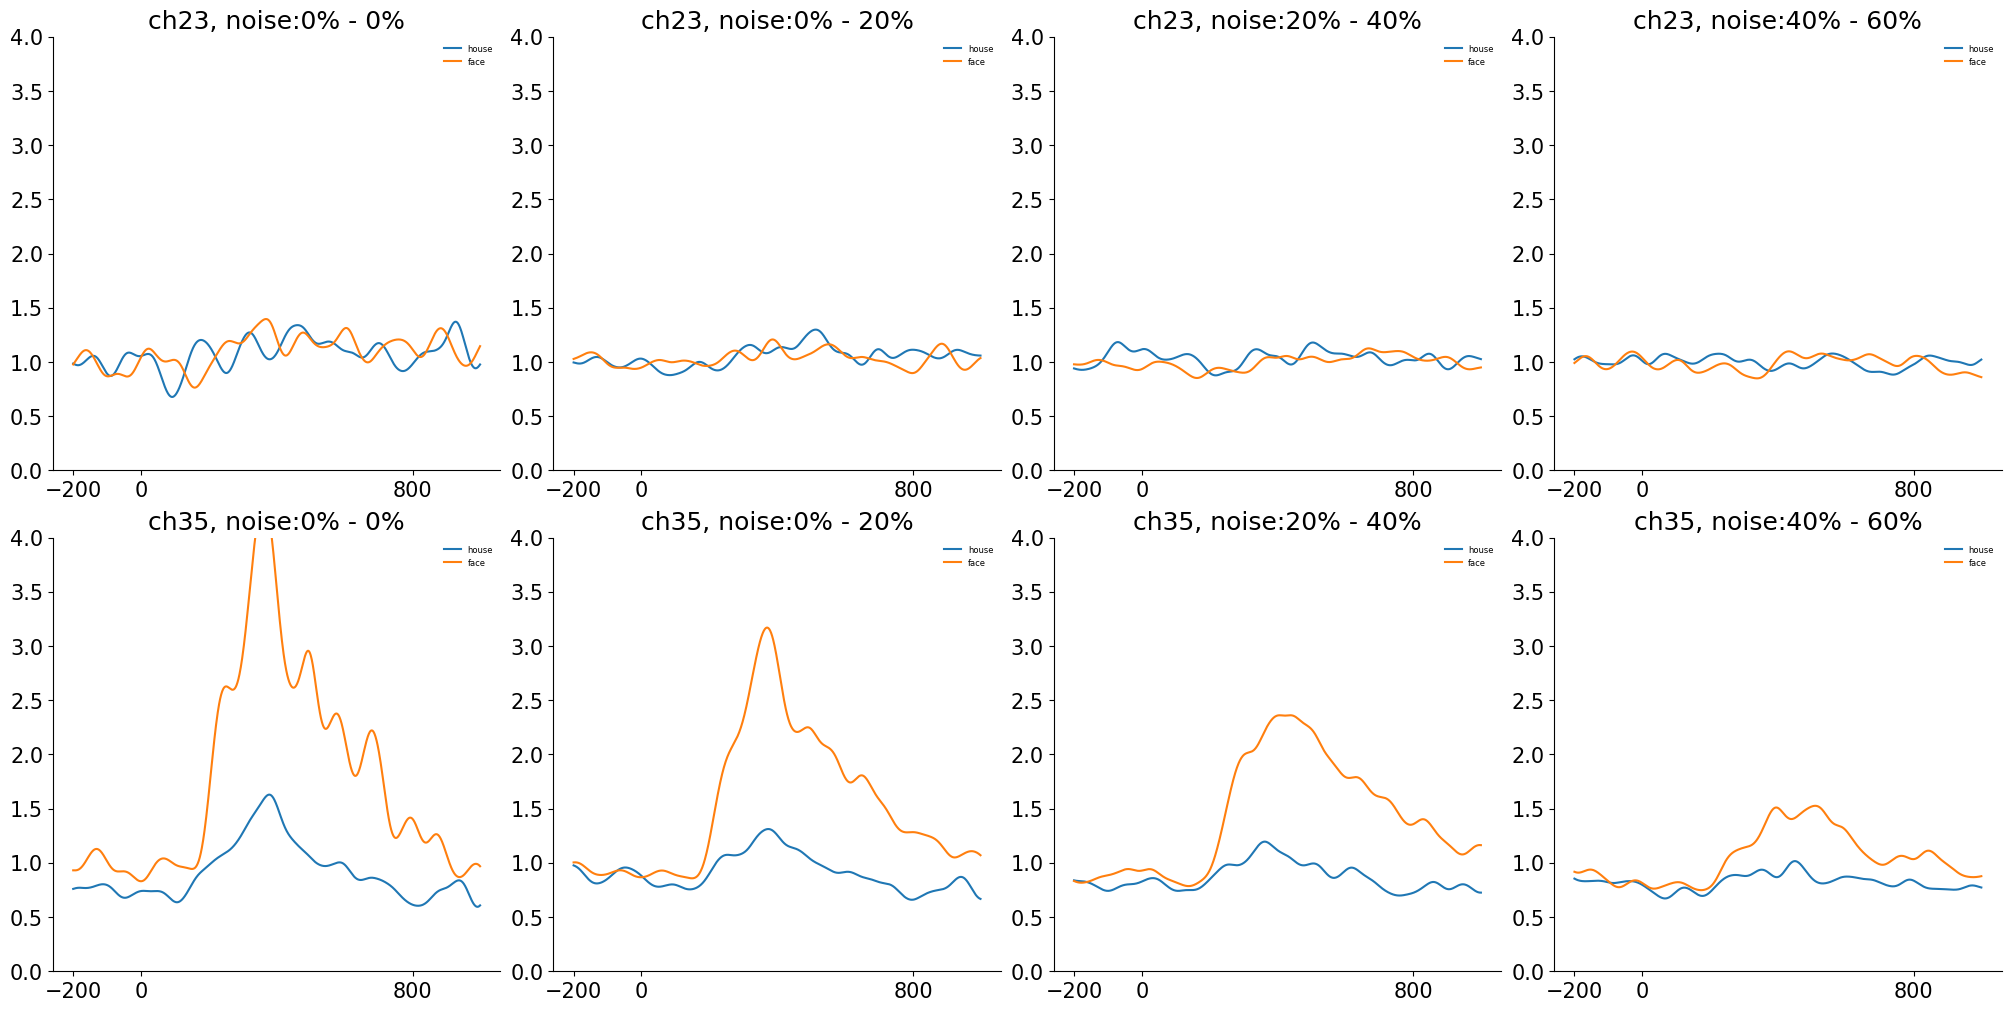

In [ ]:
#noise_limit=20 #尝试了0.2 0.4 0.6
noise_array=np.array([0,20,40,60])

fig, axs = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)
for row,ch in enumerate([23,35]):
  for col,noise in enumerate(noise_array):
    ax = axs[row, col]
    noise_min=noise-20
    if noise==0:
      noise_min=0
    #endif
    V2_house_noise = (V2_epochs[((noise_index >= (noise_min)) & (noise_index <= noise)) & (stim_cata == 1)]).mean(0)
    V2_face_noise = (V2_epochs[((noise_index >= (noise_min)) & (noise_index<=noise)) &(stim_cata==2)]).mean(0)
    ax.plot(trange, V2_house_noise[:, ch],label='house')
    ax.plot(trange, V2_face_noise[:, ch],label='face')
    ax.set_title('ch%d, noise:%d%% - %d%%' % (ch, noise_min , noise))
    ax.set_xticks([-200, 0, 800])
    ax.set_ylim([0, 4])
    ax.legend(loc='upper right', fontsize=6, frameon=False)#用于在图表中添加图例

plt.show()

发现35号电极在noise_limit<=20,40,60%都对faces有显著的识别作用,而随着噪声成分增加，43号电极越来越不能分辨面部/房子   
如果将noise_limit==60%，所有电极区域都不具备分辨能力。  
Step 1完成

## Step 4: compute TP and FN
psychometric performance

In [ ]:
t_on=dat2['t_on']
t_off=dat2['t_off']
key_press=dat2['key_press']
key_cat=np.ones_like(t_on)#初始化为全1数组

In [ ]:
#使用广播机制
key_press_matrix = key_press[:, np.newaxis]

# 找出 key_press 在 t_on[i] 到 t_on[i] + 1000 范围内的元素
key_press_within_range = (key_press_matrix >= t_on) & (key_press_matrix < t_off)

# 如果范围内有 key_press 的元素，则将 key_cat 对应的元素设置为 0
key_cat[np.any(key_press_within_range, axis=0)] = 0

In [ ]:
#compute TN, FP T为房子
from sklearn.metrics import confusion_matrix
label_true=dat2['stim_cat'].squeeze()
label_true=label_true.copy()
label_true[label_true==2]=0 #使用深拷贝避免修改dat2['stim_cat']的内容
label_predict=key_cat
tn, fp, fn, tp = confusion_matrix(label_true, label_predict).ravel()
tp_rate = tp / (tp + fn)
fn_rate = fn / (tp + fn)
precision_rate = tp/(tp+fp)
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives (tn): {tn}")
print(f"False Positives (fp): {fp}")

print(f"TP Rate (Recall): {tp_rate}")
print(f"Presicion Rate (Precision): {precision_rate}")
print(f"FN Rate: {fn_rate}")

True Positives (TP): 306
False Negatives (FN): 9
True Negatives (tn): 121
False Positives (fp): 194
TP Rate (Recall): 0.9714285714285714
Presicion Rate (Precision): 0.612
FN Rate: 0.02857142857142857


In [ ]:
print(dat2['stim_cat'])

FP：很多人脸误判成了房屋  
TP,TN:大部分能够正确分辨房屋和人脸  
FN:很少会把房屋判断成人脸
大部分情况下，被试能正确分辨房屋、人脸。在错误分类的情况中，人脸被经常错判为房屋，房屋却很少被误判成人脸

## Step 6: mistake prediction
如果能在单次试验中，某个通道检测到了响应，被试会出现错误判断。如果可以，那么说明该通道的神经响应直接反应了对噪声的感知  
35号通道对人脸图像有响应  
只要35号通道有响应，就会判断成人脸F，导致误判？  
对于FP，35通道是否都没有出现响应？  
对于FN，35号通道是否都出现了响应？  

In [ ]:
FN=np.where((label_true==1)&(label_predict==0))[0]#得到一个元组,再得到元组内的一维数组
FP=np.where((label_true==0)&(label_predict==1))[0]

In [ ]:

nt, nchan = V2.shape
nstim = len(dat2['t_on'])
trange = np.arange(-200, 1000)
ts = dat2['t_on'][:, np.newaxis] + trange
V2_epochs = np.reshape(V2[ts, :], (nstim, 1200, nchan))
stim_cata=dat2['stim_cat'].squeeze()
noise_index=dat2['stim_noise'].squeeze()
noise_limit=10 #尝试了0.2 0.4 0.6
####
V2_house_noise_ch=(V2_epochs[(noise_index<=noise_limit)&(label_true==1)]).mean(0)
V2_face_noise_ch=(V2_epochs[(noise_index<=noise_limit)&(label_true==0)]).mean(0)# 0是face




noise_limit:  10 %


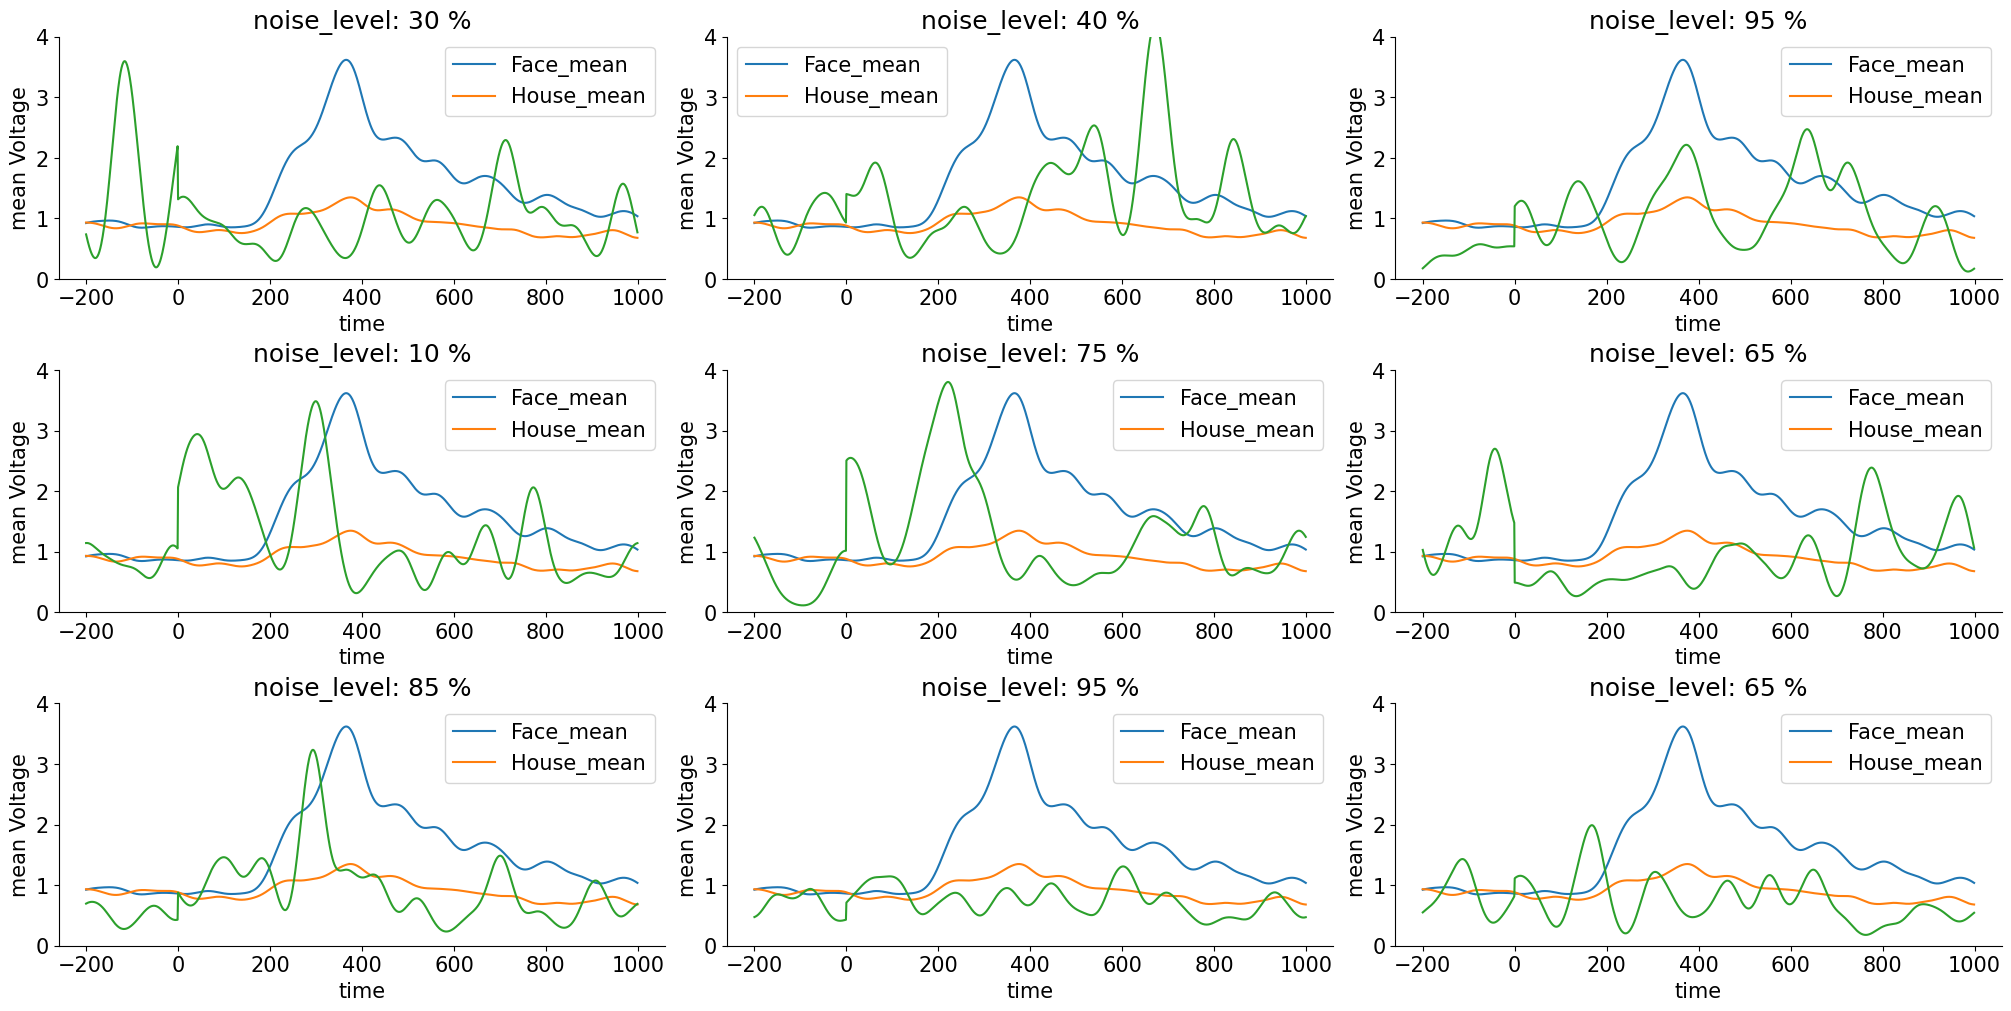

In [ ]:
#查看FN的电压，理论上35号电极有明显响应
#绘制平均无噪响应和FN响应曲线
ch=35
V2_FN=V2_epochs[FN]
V2_FN_ch=V2_FN[:,:,ch]

fig, axes = plt.subplots(3, 3, figsize=(20, 10), constrained_layout=True)
print('noise_limit: ', noise_limit, '%')
for i, ax in enumerate(axes.flatten()):
    ax.plot(trange, V2_face_noise_ch[:, ch], label='Face_mean')
    ax.plot(trange, V2_house_noise_ch[:, ch], label='House_mean')
    ax.plot(trange, V2_FN_ch[i, trange])
    ax.set_title(f'noise_level: {noise_index[FN[i]]} %')
    ax.set_ylim([0, 4])
    ax.set_xlabel('time')
    ax.set_ylabel('mean Voltage')
    ax.legend()


plt.show()


以上9张为被判定为人脸，但实际为房屋的，加入了0-10%噪声的响应曲线，说明当35号电极响应时，图片被被试判定为人脸  
  
加入了95%噪声的图片没有明显的响应，但被判定为了人脸，可能是被试猜测的  
对于FP，35号电极是否都没有出现响应？

In [ ]:
#绘制FP的电压/时间曲线图
ch=35
V2_FP=V2_epochs[FP]
print(V2_FP.shape)

(194, 1200, 41)


In [ ]:
## TD 在噪声值为10以下时画出曲线

In [ ]:
noise_for_FP=10
condition1 = np.isin(np.arange(len(noise_index)), FP)#使用np.isin来检查该范围数组中的每个索引是否存在于FP数组中
condition2 = noise_index <= noise_for_FP
condition = np.logical_and(condition1, condition2)

V2_FP_Noise_Limit = V2_epochs[condition]
#V2_FP_Noise_Limit = V2_epochs[final_indices]

In [ ]:

V2_FP_ch=V2_FP[:,:,ch].mean(0)

plt.figure(figsize=(20, 10), constrained_layout=True)

plt.plot()
plt.xlabel('time')
plt.ylabel('mean Voltage')
plt.plot(trange, V2_face_noise[:, ch], label='Face_mean')
plt.plot(trange, V2_house_noise[:, ch], label='House_mean')
plt.ylim([0, 4])

plt.plot(trange, V2_FP_ch)

plt.show()

In [ ]:
print('FP mean noise_level: ',noise_index[FP].mean(),'%')
print('FN mean noise_level: ',noise_index[FN].mean(),'%')

FP mean noise_level:  65.97938144329896 %
FN mean noise_level:  62.22222222222222 %


发现被错误判断为房子的试验中，35号电极的平均响应曲线和10%噪声下的房子图片响应曲线吻合，说明这些图片被错误地判断为房子和35号电极处没有神经响应有关  
所以基本可以预测：如果35号电极没有响应，那么被试就会把图片判断为房屋。如果有响应，则会判断为人脸

In [ ]:
#subjects performances under a given noise level
noise_level=10
ch=35
key_cat
label_true
label_predict
V_noisy_ch=V2_epochs[:,:,ch]
